In [3]:
import matplotlib.pyplot as plt
from src.args.base_args import B2TDatasetArgsModel
from src.args.yaml_config import YamlConfig
from src.datasets.brain2text import Brain2TextDataset
from matplotlib.animation import FuncAnimation
import numpy as np
import torch
from pathlib import Path
from typing import Literal

yaml_config = YamlConfig().config
config = B2TDatasetArgsModel()

In [4]:
config.preprocessing = "seperate_zscoring"
config.window_size = 4
ds = Brain2TextDataset(config=config, yaml_config=yaml_config)

Got tokenizer from file


In [5]:
sample_idx = 0

sentence = ds.tokenizer.decode(ds.encoded_sentences[0].ids)
brain_data = ds.brain_data_samples[0]

In [6]:
brain_data.shape

torch.Size([931, 256])

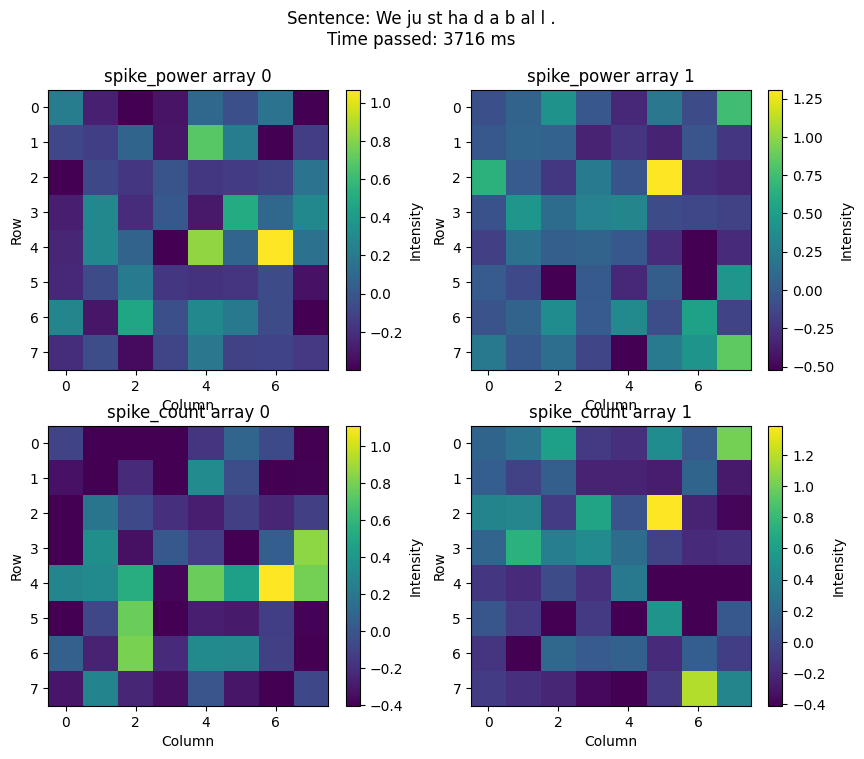

In [8]:
def rolling_mean_for_each_feature(tensor, window_size):
    num_features = tensor.size(1)
    result = torch.zeros_like(tensor)
    
    if result.shape[0] % 2 == 1:
        result = result[:-1,:]

    for feature_index in range(num_features):
        feature_data = tensor[:, feature_index]
        # Use a 1D convolution to compute the rolling mean
        conv_weights = torch.ones(window_size) / window_size
        conv_weights = conv_weights.double()
        rolling_mean = torch.nn.functional.conv1d(feature_data.view(1, 1, -1), 
                                                   weight=conv_weights.view(1, 1, -1), 
                                                   padding=(window_size - 1) // 2)[0, 0, :]
        # Ensure the result has the same shape as the input tensor
        result[:, feature_index] = rolling_mean

    return result

def save_heatmap_gif(arrays, sentence, feature_type):
    if feature_type == "spike_count" or feature_type == "spike_power":
        assert len(arrays) == 2
    elif feature_type == "mixed":
        assert len(arrays) == 4
        
    cols = 2
    rows = 2 if feature_type == 'mixed' else 1
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 8))
    fig.suptitle(f"Sentence: {sentence}\nTime passed: 0 ms")

    heatmaps = []
    for idx, array in enumerate(arrays):
        i = idx // 2
        j = idx % 2
        ax = axs[i, j]
        t = np.linspace(0, 3, 40)

        # Initialize the first frame of brain_data
        frame_data = array[0, :].reshape((8, 8))

        # Create an initial heatmap
        heatmap = ax.imshow(frame_data, cmap='viridis', interpolation='nearest')

        ax.set(xlabel='Column', ylabel='Row')
        
        feature_name = ("spike_power" if i == 0 else "spike_count") if feature_type == "mixed" else feature_type
        
        ax.set_title(f"{feature_name} array {j}")

        plt.colorbar(heatmap, ax=ax, label='Intensity')

        heatmaps.append(heatmap)

    def update(frame):
        for idx, heatmap in enumerate(heatmaps):
            i = idx // 2
            j = idx % 2
            
            idx = 2*i+j

            # Extract frame data and reshape into a 2D array
            frame_data = arrays[idx][frame, 0:64].reshape((8, 8))

            # Update the data in the heatmap
            heatmap.set_array(frame_data)

        fig.suptitle(f"Sentence: {sentence}\nTime passed: {frame * config.window_size} ms")
        return heatmaps

    # Set up the animation
    animation = FuncAnimation(fig, update, frames=range(len(arrays[0]) - (arrays[0].shape[0] % 2)), interval=250, repeat=False)
    animation.save(Path(yaml_config.fig_dir) / "brain_animation_heatmap.gif", writer='pillow', fps=15)

def visualize_array_over_time(data, sentence, feature_type: Literal["spike_pow", "spike_count", "mixed"], window_size):
    arrays = []
    for i in range(int(data.shape[1]/64)):
        smoothed_array = rolling_mean_for_each_feature(data[:, i * 64: (i+1) * 64], window_size)
        arrays.append(smoothed_array)
    save_heatmap_gif(arrays, sentence, feature_type)
        
visualize_array_over_time(brain_data, sentence, "mixed", 50)

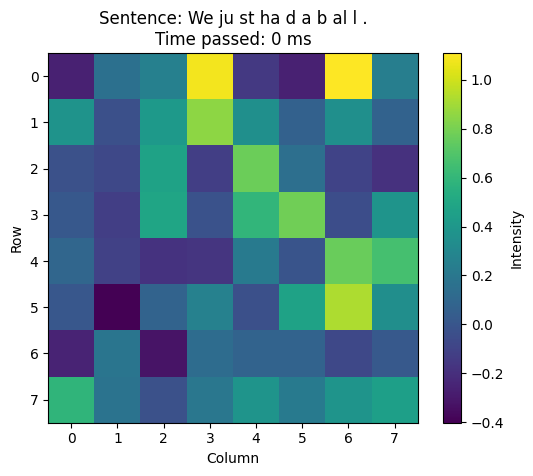

In [ ]:
fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)

# Initialize the first frame of brain_data
frame_data = rolling_mean_features[0, 0:64].reshape((8, 8))

# Create an initial heatmap
heatmap = ax.imshow(frame_data, cmap='viridis', interpolation='nearest')

ax.set(xlabel='Column', ylabel='Row', title=f"Sentence: {sentence}\nTime passed: 0 ms")

plt.colorbar(heatmap, ax=ax, label='Intensity')

def update(frame):
    # Extract frame data and reshape into a 2D array
    frame_data = rolling_mean_features[frame, 0:64].reshape((8, 8))

    # Update the data in the heatmap
    heatmap.set_array(frame_data)
    ax.set(title=f"Sentence: {sentence}\nTime passed: {config.window_size * frame} ms")

    return [heatmap]

# Set up the animation
animation = FuncAnimation(fig, update, frames=range(len(brain_data) - (brain_data.shape[0] % 2)), interval=250, repeat=False)
animation.save(Path(yaml_config.fig_dir) / "brain_animation_heatmap.gif", writer='pillow', fps=15)